In [1]:
cd ..

/ssd_data_tgreer/rl/comp_755_project


In [20]:
import collections
import functools
import os
import pickle
from pydoc import locate
import time
import zlib

from absl import app
from absl import flags
from absl import logging
import cma
import numpy as np
import rpyc
import tensorflow as tf

from rl755.common import misc
from rl755.data_gen import gym_rollouts
from rl755.models.policy import PolicyWrapper

ACTION_SIZE = 15

FLAGS = lambda: None
flags = FLAGS
flags.environment = "caveflyer"
  

flags.controller = "LinearController"

flags.vision_model = 'vae_32d'
flags.memory_model = 'deterministic_transformer_32dm_32di'

flags.sequence_length = 32


flags.cma_population_size = 32
flags.cma_trials_per_member = 12
flags.cma_steps = 1000

flags.rollout_max_steps = 1000

from matplotlib import animation
from IPython.display import HTML

#for frame in video:
#    cv2.imshow("title", frame)
#    cv2.waitKey(1)
    
def jupyter_video(video):
    fig = plt.figure()
    im = plt.imshow(video[0,:,:,:])

    plt.close() # this is required to not display the generated image

    def init():
        im.set_data(video[0,:,:,:])

    def animate(i):
        im.set_data(video[i,:,:,:])
        return im

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                                   interval=50)
    return HTML(anim.to_html5_video())


def get_vision_model():
    model = locate(
        f"rl755.models.vision.vision_trained.{FLAGS.vision_model}"
    )
    return model(FLAGS.environment)


def get_memory_model():
    model = locate(
        f"rl755.models.memory.memory_trained.{FLAGS.memory_model}"
    )
    return model(FLAGS.environment)


def get_controller_cls():
    return locate(f"rl755.models.controller.controllers.{FLAGS.controller}")




def get_in_out_sizes(vision_model, memory_model):
    in_size = (
        vision_model.get_representation_size() + memory_model.get_representation_size()
    )
    out_size = ACTION_SIZE
    return in_size, out_size

rollout_state = None
def get_scores(solutions, vision_model, memory_model, max_steps):
    global rollout_state
    Controller = get_controller_cls()
    in_size, out_size = get_in_out_sizes(vision_model, memory_model)

    learned_policy = Controller.from_flat_arrays(
        solutions, in_size=in_size, out_size=out_size
    )
    policy = PolicyWrapper(
        vision_model=vision_model,
        memory_model=memory_model,
        learned_policy=learned_policy,
        max_seqlen=FLAGS.sequence_length,
    )
    # TODO: Maybe add some form of stopping if all are complete. IDK if this happens
    # often enough to be a benefit.
    rollout_state = gym_rollouts.perform_rollouts(
        env_name=FLAGS.environment,
        num_envs=len(solutions),
        policy=policy,
        max_steps=FLAGS.rollout_max_steps,
    )
    return rollout_state.get_first_rollout_total_reward().tolist()


def save_checkpoint(step, solutions, fitlist):
    obj = {
        "step": step,
        "solutions": solutions,
        "fitlist": fitlist,
    }
    checkpoint_file = os.path.join(FLAGS.model_dir, f"checkpoint-{step:03d}.pickle")
    with open(checkpoint_file, "wb") as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)



In [50]:
with open("../tmp/caveflyer/controllers/linear_controller/checkpoint-011.pickle", "rb") as f:
    obj = pickle.load(f)
    solutions = obj["solutions"]
    fitlist = obj["fitlist"]
    solution = solutions[np.argmax(fitlist)]

In [51]:

vision_model = get_vision_model()
memory_model = get_memory_model()

scores = get_scores(
    [solution],
    vision_model=vision_model,
    memory_model=memory_model,
    max_steps=1000,
)
    

TODO: THIS MODEL ISN'T TRAINED. LOAD WEIGHTS!!!
TODO: Make sure everything in this class lines up!!!


In [52]:
obs = rollout_state.observations

In [53]:
import matplotlib.pyplot as plt

In [54]:
obs.shape

(1001, 1, 64, 64, 3)

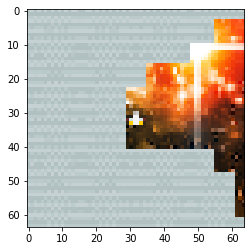

In [55]:
plt.imshow(obs[0, 0])

In [56]:
jupyter_video(obs[:,0])

In [57]:
obs_encoded = vision_model.encode(obs[:, 0] / 255.)

In [58]:
obs_decoded = vision_model.decode(obs_encoded.sample())

In [59]:
jupyter_video(np.concatenate([obs_decoded, obs[:, 0] / 255.], -2))